<a href="https://colab.research.google.com/github/ML-HW-SYS/a2/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/drive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/drive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/drive/MyDrive/ece5545
%cd /content/drive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/drive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/drive/MyDrive/ece5545

PROJECT_ROOT = f"/content/drive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/drive/MyDrive/ece5545’: File exists
/content/drive/MyDrive/ece5545
fatal: destination path 'a2-NamanMakkar' already exists and is not an empty directory.
/content/drive/MyDrive/ece5545/a2-NamanMakkar
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/drive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [5]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import code dependencies

In [6]:
# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will 
# reproduce the training and testing results  
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/drive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/drive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/drive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/drive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/drive/MyDrive/ece5545/models/micro_models.


## 6.1 Prepare for Training



In [7]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [8]:
TORCH_DIR = PROJECT_ROOT

In [9]:
!ls {TORCH_DIR}

 1_audio_preprocessing.ipynb
 2_size_estimator_and_profiler.ipynb
 3_training_and_analysis.ipynb
 4_model_conversion.ipynb
 5_quantization.ipynb
 6_pruning.ipynb
 arduino_nano_33_ble_tutorial.md
 fp32_checkpoint.pt
 fp32_finetune_checkpoint.pt
 images
 pruned_finetuning_thresh_0.2.pt
 pruned_finetuning_thresh_0.4.pt
 pruned_finetuning_thresh_0.5.pt
 pruned_finetuning_thresh_0.6.pt
 pruned_finetuning_thresh_0.8.pt
'(QAT6bit)quant_0.pt'
'(QAT8bit)quant_0.pt'
 quant_checkpoint.pt
 README.md
 src
 tests
 tinyconv_float32_init_seed0_90.28%_0.pt
 unstructured_pruned_finetuning_thresh_0.2.pt
 unstructured_pruned_finetuning_thresh_0.4.pt
 unstructured_pruned_finetuning_thresh_0.5.pt
 unstructured_pruned_finetuning_thresh_0.6.pt
 unstructured_pruned_finetuning_thresh_0.8.pt


### **TODO: Replace the torch_path model with the model you created in the last section.** 

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [29]:
# TODO: Replace me!
#torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path =  os.path.join(TORCH_DIR, "pruned_finetuning_thresh_0.5.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path, map_location=device)['model_state_dict'])
#model_fp32.load_state_dict(torch.load(torch_path, map_location=device))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ), TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

In [30]:
model_fp32.conv.weight.data

tensor([[[[-1.6049e-01, -8.5469e-02, -6.7049e-02, -4.6235e-02, -5.1525e-02,
            1.9815e-02,  4.9400e-02,  8.2303e-02],
          [-1.6177e-01, -3.6699e-02, -6.6552e-02, -2.4029e-02, -9.1410e-02,
            1.4213e-02,  3.7170e-02,  6.5822e-02],
          [-9.6092e-02, -2.3452e-03, -1.1228e-01, -2.9051e-02, -7.0529e-02,
            1.8248e-02,  8.1261e-03,  7.4339e-02],
          [-1.1286e-01, -3.1520e-03, -8.3295e-02, -3.4378e-02, -8.0701e-02,
            1.8453e-02,  1.4996e-03,  6.1127e-02],
          [-1.1873e-01, -1.6398e-02, -5.0417e-02, -2.0638e-02, -6.2827e-02,
            1.4661e-02, -4.2346e-03,  4.9553e-02],
          [-7.4801e-02, -3.1919e-02, -4.8221e-02, -3.3690e-02, -5.7196e-02,
            2.0427e-02,  4.9610e-03,  6.9946e-02],
          [-5.7756e-02, -7.4576e-03, -3.0986e-03, -5.2570e-03, -3.3491e-02,
           -1.2452e-02,  6.6083e-03,  1.8607e-02],
          [ 2.4412e-02, -1.8091e-02, -2.3362e-02, -7.4495e-04, -1.5235e-02,
           -1.2664e-03,  1.2884e-02

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
from src.size_estimate import count_trainable_parameters
from src.size_estimate import flop
from torch.nn.utils import prune
from src.train_val_test_utils import test

def structured_pruning(model, threshold, n=1):
  m = copy.deepcopy(model)
  m.train()
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.ln_structured(module, name='weight', n=n, amount=threshold, dim=0)
      prune.remove(module, 'weight')
  return m

def unstructured_pruning(model, threshold):
  prune_iterations = 3
  #for name, module in m.named_modules():
  #  if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
  #    prune.random_unstructured(module, name='weight', amount=threshold)
  #    prune.remove(module, 'weight')

  prune_params = (
    (model.conv, 'weight'),
    (model.fc, 'weight'))
  
  prune_amounts = 0.5

  # Apply the pruning
  prune.global_unstructured(
    prune_params,
    pruning_method=prune.L1Unstructured,
    amount=prune_amounts)
  
  prune.remove(model.conv, 'weight')
  prune.remove(model.fc, 'weight')
  
  return model

def prune_unstr(model, threshold):
  model2 = copy.deepcopy(model)
  params_to_prune = [(module, 'weight') for module in filter(lambda m: type(m) == torch.nn.Conv2d, model2.modules())]
  prune.global_unstructured(params_to_prune, pruning_method=prune.L1Unstructured, amount=threshold)
  for module, name in params_to_prune:
    prune.remove(module, name)
  return model2

'''prune_params = (
    (model_fp32.conv, 'weight'),
    (model_fp32.fc, 'weight'))

prune_amounts = 0.5

prune.global_unstructured(
    prune_params,
    pruning_method=prune.L1Unstructured,
    amount=prune_amounts)
  
prune.remove(model_fp32.conv, 'weight')
prune.remove(model_fp32.fc, 'weight') '''

#m = copy.deepcopy(model_fp32)
#model_fp32.train()

#m = structured_pruning(model_fp32,0.5,n=1)
#total_params = sum(p.numel() for p in model_fp32.parameters() if p.requires_grad)
#total_params_pruned = sum(p.numel() for p in m.parameters() if p.requires_grad and p.numel() != 0)
#print(total_params_pruned)

16652


In [ ]:
#m

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
#m.conv.weight.nelement()

640

In [ ]:
#float(m.conv.weight.nelement() - torch.sum(m.conv.weight == 0) + m.conv.bias.nelement() + m.fc.weight.nelement() - torch.sum(m.fc.weight == 0) + m.fc.bias.nelement())

8332.0

In [ ]:
#print(total_params)

16652


In [ ]:
#model_fp32 == structured_pruning(model_fp32, 0.5)

False

In [36]:
from src.size_estimate import count_trainable_parameters
from src.size_estimate import flop
import torch.nn.utils.prune as prune
from src.train_val_test_utils import test

def structured_pruning(model, threshold, n=1):
  m = copy.deepcopy(model)
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.ln_structured(module, name='weight', n=n, amount=threshold, dim=0)
      prune.remove(module, 'weight')
  return m

#thresholds = [0.2, 0.4, 0.5, 0.6, 0.9]

#m = structured_pruning(model_fp32, 0.85, n=1)
#m.conv.weight.data

tensor([[[[-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
            0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
            0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
            0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
            0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
            0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
            0.0000],
          [-0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
           -0.0000],
          [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
           -0.0000],
          [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
           -0.0000],
          [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
           -0.0000]]],


        [[[-0.0000,  0.0000,  0.0000,  0.0000,

In [12]:
from src.size_estimate import count_trainable_parameters
from src.size_estimate import flop
import torch.nn.utils.prune as prune
from src.train_val_test_utils import test

def structured_pruning(model, threshold, n=1):
  m = copy.deepcopy(model)
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.ln_structured(module, name='weight', n=n, amount=threshold, dim=0)
      prune.remove(module, 'weight')
  return m

thresholds = [0.2, 0.4, 0.5, 0.6, 0.9]

pruned_models = []
params_pruned_models = []
flops_pruned_models = []
pruned_model_accs = []

for thr in thresholds:
  m = structured_pruning(model_fp32,thr,n=1) #L1 structured pruning
  m.to(device)
  flop_by_layers = flop(
    model=m, 
    input_shape=(
        1, 
        m.model_settings['fingerprint_width'], 
        m.model_settings['spectrogram_length']
    ), 
    device=device)
  pruned_models.append(m)
  params_pruned_models.append(float(m.conv.weight.nelement() - torch.sum(m.conv.weight == 0) + m.conv.bias.nelement() + m.fc.weight.nelement() - torch.sum(m.fc.weight == 0) + m.fc.bias.nelement()))
  #flops_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

for m in pruned_models:
  acc = test(test_loader, m, device)
  pruned_model_accs.append(acc)

print(pruned_model_accs)
#print(flops_pruned_models)
print(params_pruned_models)

[81.0672514619883, 71.56432748538012, 52.046783625730995, 50.219298245614034, 19.883040935672515]
[12492.0, 8412.0, 8332.0, 8252.0, 92.0]


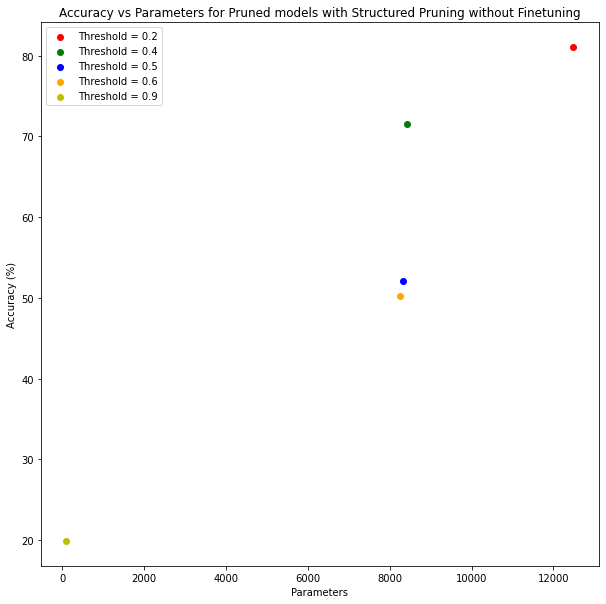

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs Parameters for Pruned models with Structured Pruning without Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(params_pruned_models[idx],pruned_model_accs[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_acc_structured_pruned_models.png')
plt.show()

In [14]:
# Finetuning the pruned models
from src.train_val_test_utils import create_optimizer
from src.train_val_test_utils import train, test
import os

pruned_finetuned_test_acc = []
num_batches = len(train_loader)
for idx,model in enumerate(pruned_models):
  model.train()
  optimizer_fp32 = create_optimizer(model=model, learning_rate=0.001)
  checkpoint_path = os.path.join(TORCH_DIR, f'pruned_finetuning_thresh_{thresholds[idx]}.pt')
  print(f'Finetuning for model with threshold = {thresholds[idx]}')
  last_valacc = 0
  for ep in range(1,11):
    print(f'Epoch: {ep}')
    train_iters = len(train_loader)
    train(model, data_loaders, optimizer_fp32, ep, device)
    val_acc = test(valid_loader, model, device, epoch=ep, loader_type='Valid', verbose=True)
    if val_acc > last_valacc:
      last_valacc = val_acc
      torch.save({'epoch': ep,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer_fp32.state_dict()
                }, checkpoint_path)
  test_acc = test(test_loader, model, device, epoch=None, loader_type='Test')
  print(f'Test Acc = {round(test_acc,2)}%')
  pruned_finetuned_test_acc.append(test_acc)

print(pruned_finetuned_test_acc)

Finetuning for model with threshold = 0.2
Epoch: 1
Val Acc Epoch 1 = 88.3%, Train loss = 0.465

Valid epoch: 1	Accuracy: 1171/1333 (87.85%)

Epoch: 2
Val Acc Epoch 2 = 87.77%, Train loss = 0.424

Valid epoch: 2	Accuracy: 1179/1333 (88.45%)

Epoch: 3
Val Acc Epoch 3 = 89.12%, Train loss = 0.401

Valid epoch: 3	Accuracy: 1186/1333 (88.97%)

Epoch: 4
Val Acc Epoch 4 = 87.85%, Train loss = 0.401

Valid epoch: 4	Accuracy: 1191/1333 (89.35%)

Epoch: 5
Val Acc Epoch 5 = 88.07%, Train loss = 0.412

Valid epoch: 5	Accuracy: 1173/1333 (88.00%)

Epoch: 6
Val Acc Epoch 6 = 88.22%, Train loss = 0.405

Valid epoch: 6	Accuracy: 1175/1333 (88.15%)

Epoch: 7
Val Acc Epoch 7 = 87.17%, Train loss = 0.401

Valid epoch: 7	Accuracy: 1163/1333 (87.25%)

Epoch: 8
Val Acc Epoch 8 = 89.05%, Train loss = 0.391

Valid epoch: 8	Accuracy: 1194/1333 (89.57%)

Epoch: 9
Val Acc Epoch 9 = 88.3%, Train loss = 0.391

Valid epoch: 9	Accuracy: 1176/1333 (88.22%)

Epoch: 10
Val Acc Epoch 10 = 87.7%, Train loss = 0.389

Vali

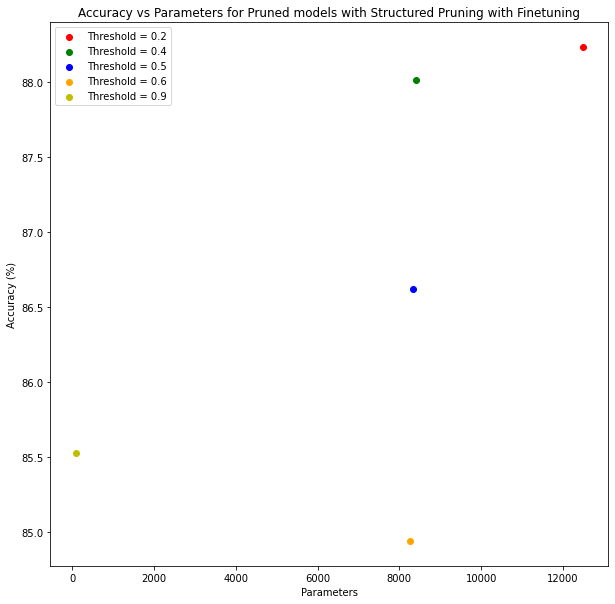

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs Parameters for Pruned models with Structured Pruning with Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(params_pruned_models[idx],pruned_finetuned_test_acc[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_acc_structured_pruned_finetuned_models.png')
plt.show()

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [16]:
def unstructured_pruning(model, threshold):
  m = copy.deepcopy(model)
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.l1_unstructured(module, amount=threshold)
      prune.remove(module, 'weight')
  return m

thresholds = [0.2, 0.4, 0.5, 0.6, 0.9]

unstructured_pruned_models = []
unstructured_params_pruned_models = []
unstructured_pruned_model_accs = []

for thr in thresholds:
  m = structured_pruning(model_fp32_orig,thr) #L1 unstructured pruning
  m.to(device)
  unstructured_pruned_models.append(m)
  unstructured_params_pruned_models.append(float(m.conv.weight.nelement() - torch.sum(m.conv.weight == 0) + m.conv.bias.nelement() + m.fc.weight.nelement() - torch.sum(m.fc.weight == 0)))

for m in unstructured_pruned_models:
  acc = test(test_loader, m, device)
  unstructured_pruned_model_accs.append(acc)

print(unstructured_pruned_model_accs)
print(unstructured_params_pruned_models)

[79.82456140350877, 72.22222222222223, 52.33918128654971, 49.41520467836257, 19.883040935672515]
[12488.0, 8408.0, 8328.0, 8248.0, 88.0]


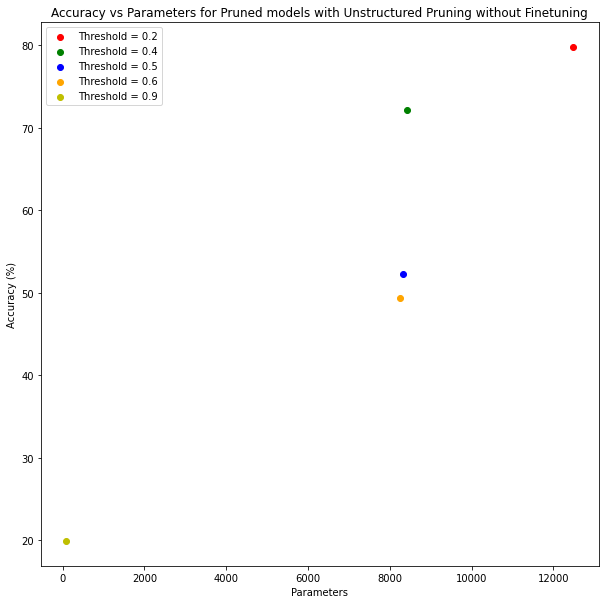

In [17]:
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs Parameters for Pruned models with Unstructured Pruning without Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(unstructured_params_pruned_models[idx],unstructured_pruned_model_accs[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_acc_unstructured_pruned_models.png')
plt.show()

In [18]:
# Finetuning the pruned models
from src.train_val_test_utils import create_optimizer
from src.train_val_test_utils import train, test
import os

unstr_pruned_finetuned_test_acc = []
num_batches = len(train_loader)
for idx,model in enumerate(unstructured_pruned_models):
  model.train()
  optimizer_fp32 = create_optimizer(model=model, learning_rate=0.001)
  checkpoint_path = os.path.join(TORCH_DIR, f'unstructured_pruned_finetuning_thresh_{thresholds[idx]}.pt')
  print(f'Finetuning for model with threshold = {thresholds[idx]}')
  last_valacc = 0
  for ep in range(1,11):
    print(f'Epoch: {ep}')
    train_iters = len(train_loader)
    train(model, data_loaders, optimizer_fp32, ep, device)
    val_acc = test(valid_loader, model, device, epoch=ep, loader_type='Valid', verbose=True)
    if val_acc > last_valacc:
      last_valacc = val_acc
      torch.save({'epoch': ep,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer_fp32.state_dict()
                }, checkpoint_path)
  test_acc = test(test_loader, model, device, epoch=None, loader_type='Test')
  print(f'Test Acc = {round(test_acc,2)}%')
  unstr_pruned_finetuned_test_acc.append(test_acc)

print(unstr_pruned_finetuned_test_acc)

Finetuning for model with threshold = 0.2
Epoch: 1
Val Acc Epoch 1 = 87.77%, Train loss = 0.449

Valid epoch: 1	Accuracy: 1172/1333 (87.92%)

Epoch: 2
Val Acc Epoch 2 = 88.37%, Train loss = 0.413

Valid epoch: 2	Accuracy: 1171/1333 (87.85%)

Epoch: 3
Val Acc Epoch 3 = 87.55%, Train loss = 0.406

Valid epoch: 3	Accuracy: 1175/1333 (88.15%)

Epoch: 4
Val Acc Epoch 4 = 87.62%, Train loss = 0.403

Valid epoch: 4	Accuracy: 1176/1333 (88.22%)

Epoch: 5
Val Acc Epoch 5 = 88.07%, Train loss = 0.41

Valid epoch: 5	Accuracy: 1177/1333 (88.30%)

Epoch: 6
Val Acc Epoch 6 = 89.12%, Train loss = 0.402

Valid epoch: 6	Accuracy: 1184/1333 (88.82%)

Epoch: 7
Val Acc Epoch 7 = 88.9%, Train loss = 0.387

Valid epoch: 7	Accuracy: 1182/1333 (88.67%)

Epoch: 8
Val Acc Epoch 8 = 88.22%, Train loss = 0.392

Valid epoch: 8	Accuracy: 1185/1333 (88.90%)

Epoch: 9
Val Acc Epoch 9 = 88.52%, Train loss = 0.39

Valid epoch: 9	Accuracy: 1175/1333 (88.15%)

Epoch: 10
Val Acc Epoch 10 = 89.05%, Train loss = 0.388

Vali

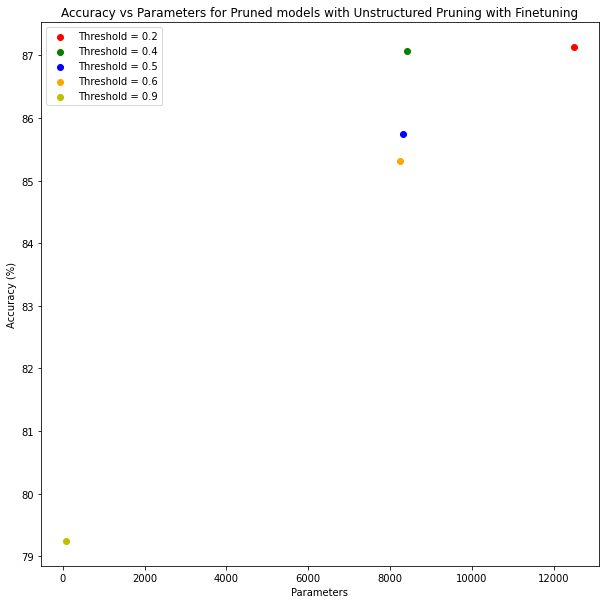

In [19]:
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs Parameters for Pruned models with Unstructured Pruning with Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(unstructured_params_pruned_models[idx],unstr_pruned_finetuned_test_acc[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_acc_unstructured_pruned_models_with_finetuning.png')
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define tiny_conv model
class Reshape(nn.Module):
    def __init__(self, output_shape):
        super(Reshape, self).__init__()
        self.output_shape = output_shape

    def __repr__(self):
        s = super().__repr__()
        s = f'{s[:-1]}output_shape={tuple(self.output_shape)})'
        return s

    def forward(self, x):
        reshaped_input = torch.reshape(x, self.output_shape)
        return reshaped_input


class TinyConvPruned(nn.Module):
    def __init__(self, model_settings, n_input=1, n_output=4, num_channels=6, fc_feats=4000):
        super(TinyConvPruned, self).__init__()
        first_filter_width = 8
        first_filter_height = 10
        first_filter_count = num_channels
        first_conv_stride_x = 2
        first_conv_stride_y = 2
        self.model_settings = model_settings

        input_frequency_size = self.model_settings['fingerprint_width']
        input_time_size = self.model_settings['spectrogram_length']
        W = input_frequency_size
        H = input_time_size
        C = 1

        # Reshape layer
        self.conv_reshape = Reshape([-1, C, H, W])

        # Conv2d layer
        self.conv = nn.Conv2d(in_channels=n_input,
                              out_channels=first_filter_count,
                              kernel_size=
                              (first_filter_height, first_filter_width),
                              stride=(first_conv_stride_y, first_conv_stride_x),
                              padding=(5, 3))

        # Relu layer
        self.relu = nn.ReLU()

        # Dropout layer
        #self.dropout = nn.Dropout()

        # Reshape layer
        fc_in_features = fc_feats
        self.fc_reshape = Reshape([-1, fc_in_features])

        # Fully Connected layer
        self.fc = nn.Linear(in_features=fc_in_features, out_features=n_output)

        # Softmax
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # Reshape input x
        x = self.conv_reshape(x)

        # Pass x through conv2d layer
        x_conv = self.conv(x)

        # Pass x through relu layer
        x_relu = self.relu(x_conv)

        # Pass x through dropout layer during tesing
        #if self.training:
        #    x_dropout = self.dropout(x_relu)
        #else:
        #    x_dropout = x_relu

        # Reshape x
        x_reshaped = self.fc_reshape(x_relu)
        #print(x_reshaped.shape)
        # Pass x through fully connected layer
        x_fc = self.fc(x_reshaped)

        # Pass x through softmax layer
        if self.training:
            y = F.log_softmax(x_fc,-1)
        else:
            y = self.softmax(x_fc)

        return y

model_pruned_thresh_0_2 = TinyConvPruned(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=6, fc_feats=3000)
model_pruned_thresh_0_4 = TinyConvPruned(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=5, fc_feats=2500)
model_pruned_thresh_0_5 = TinyConvPruned(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=4, fc_feats=2000)
model_pruned_thresh_0_6 = TinyConvPruned(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=3, fc_feats=1500)
model_pruned_thresh_0_9 = TinyConvPruned(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=1, fc_feats=500)
model_pruned_thresh_0_2.to(device)
model_pruned_thresh_0_4.to(device)
model_pruned_thresh_0_5.to(device)
model_pruned_thresh_0_6.to(device)
model_pruned_thresh_0_9.to(device)

TinyConvPruned(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 1, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (fc_reshape): Reshape(output_shape=(-1, 500))
  (fc): Linear(in_features=500, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [32]:
from src.size_estimate import flop
flops_struct_pruned_models = []
flop_by_layers = flop(
    model=model_pruned_thresh_0_2, 
    input_shape=(
        1, 
        model_pruned_thresh_0_2.model_settings['fingerprint_width'], 
        model_pruned_thresh_0_2.model_settings['spectrogram_length']
    ), 
    device=device)
flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

In [33]:
flop_by_layers = flop(
    model=model_pruned_thresh_0_4, 
    input_shape=(
        1, 
        model_pruned_thresh_0_4.model_settings['fingerprint_width'], 
        model_pruned_thresh_0_4.model_settings['spectrogram_length']
    ), 
    device=device)
flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

In [34]:
flop_by_layers = flop(
    model=model_pruned_thresh_0_5, 
    input_shape=(
        1, 
        model_pruned_thresh_0_5.model_settings['fingerprint_width'], 
        model_pruned_thresh_0_5.model_settings['spectrogram_length']
    ), 
    device=device)
flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

In [35]:
flop_by_layers = flop(
    model=model_pruned_thresh_0_6, 
    input_shape=(
        1, 
        model_pruned_thresh_0_6.model_settings['fingerprint_width'], 
        model_pruned_thresh_0_6.model_settings['spectrogram_length']
    ), 
    device=device)
flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

In [36]:
flop_by_layers = flop(
    model=model_pruned_thresh_0_9, 
    input_shape=(
        1, 
        model_pruned_thresh_0_9.model_settings['fingerprint_width'], 
        model_pruned_thresh_0_9.model_settings['spectrogram_length']
    ), 
    device=device)
flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

In [37]:
print(flops_struct_pruned_models)

[507004, 422504, 338004, 253504, 84504]


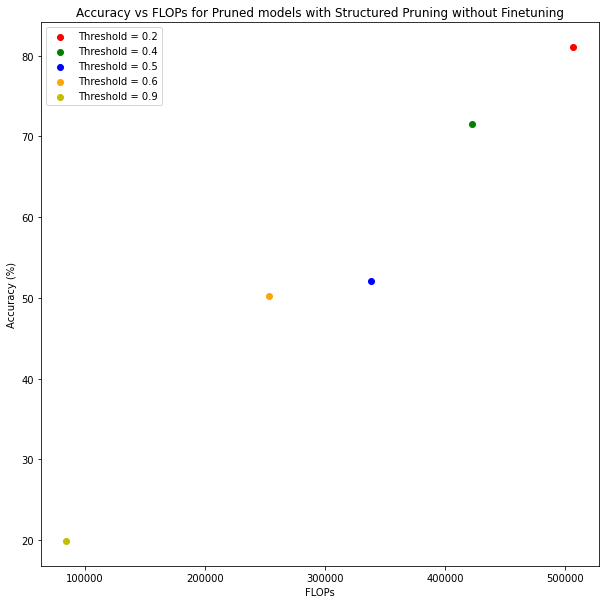

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs FLOPs for Pruned models with Structured Pruning without Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(flops_struct_pruned_models[idx],pruned_model_accs[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_flops_structured_pruned_models_no_finetune.png')
plt.show()

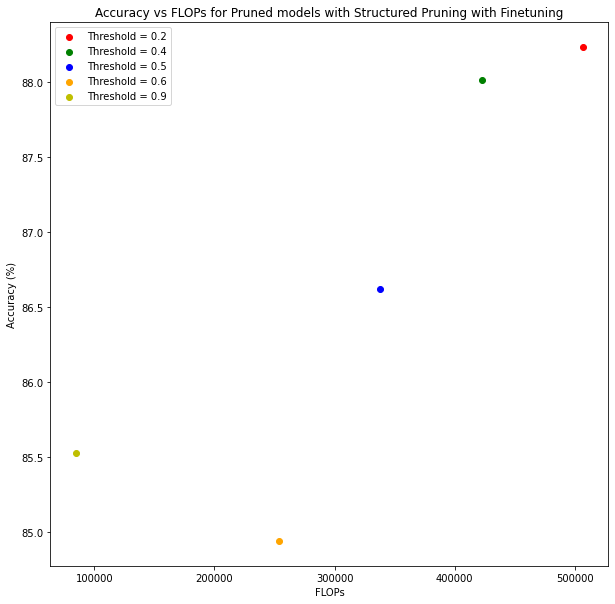

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'orange', 'y']
plt.title('Accuracy vs FLOPs for Pruned models with Structured Pruning with Finetuning')
for idx,thr in enumerate(thresholds):
  plt.scatter(flops_struct_pruned_models[idx],pruned_finetuned_test_acc[idx],color=colors[idx],label=f'Threshold = {thr}')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy (%)')
plt.legend()
fig.savefig('/content/params_vs_flops_structured_pruned_models_finetuned.png')
plt.show()